In [1]:
import torch
import torch.nn as nn

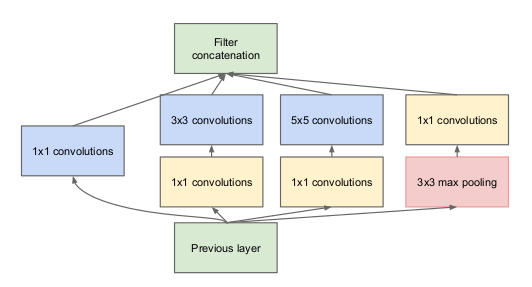

In [36]:
class conv_block(nn.Module):
  def __init__(self,in_channel,out_channel,**kwargs): #keyword arguments
    super(conv_block,self).__init__()
    self.relu=nn.ReLU()
    self.conv=nn.Conv2d(in_channel,out_channel,**kwargs)
    self.batchnorm=nn.BatchNorm2d(out_channel)

  def forward(self,x):
    return self.relu(self.batchnorm(self.conv(x)))



In [37]:
class Inception_block(nn.Module):
  def __init__(self,in_channel,out_1x1,red_3x3,out_3x3,red_5x5,out_5x5,out_1x1_pool): #all of these are conv_block
    super(Inception_block,self).__init__()

    # we have 4 branches

    self.branch1=conv_block(in_channel,out_1x1,kernel_size=1)
    self.branch2=nn.Sequential(
        conv_block(in_channel,red_3x3,kernel_size=1),
        
        conv_block(red_3x3,out_3x3,kernel_size=3,stride=1,padding=1)
    )

    self.branch3=nn.Sequential(
        conv_block(in_channel,red_5x5,kernel_size=1),
        conv_block(red_5x5,out_5x5,kernel_size=5,stride=1,padding=2)
    )

    self.branch4=nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        conv_block(in_channel,out_1x1_pool,kernel_size=1)

    )

  def forward(self,x):

    #N X filter X 28x28 , in the filter axis concat
    return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],1)


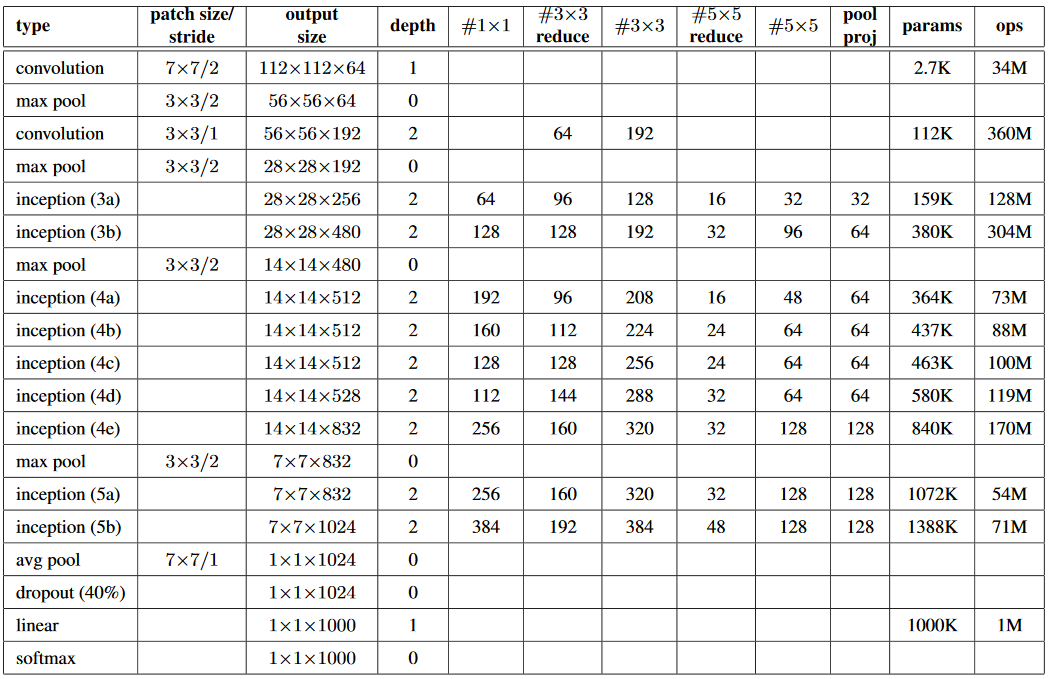

In [76]:
class GoogleNet(nn.Module):
  def __init__(self,in_channel,num_classes=1000):
    super(GoogleNet,self).__init__()

    self.conv1=conv_block(in_channel=in_channel,out_channel=64,kernel_size=(7,7),stride=(2,2),padding=(3,3))
    self.maxpool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    self.conv2=conv_block(in_channel=64,out_channel=192,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    self.maxpool2=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    #in_channel,out_1x1,red_3x3,out_3x3,red_5x5,out_5x5,out_1x1_pool

    self.inception3a=Inception_block(192,64,96,128,16,32,32)
    self.inception3b=Inception_block(256,128,128,192,32,96,64)
    self.maxpool3=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    self.inception4a=Inception_block(480,192,96,208,16,48,64)
    self.inception4b=Inception_block(512,160,112,224,24,64,64)
    self.inception4c=Inception_block(512,128,128,256,24,64,64)
    self.inception4d=Inception_block(512,112,144,288,32,64,64)
    self.inception4e=Inception_block(528,256,160,320,32,128,128)

    self.maxpool4=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    self.inception5a=Inception_block(832,256,160,320,32,128,128)
    self.inception5b=Inception_block(832,384,192,384,48,128,128)
    self.avg_pool=nn.AvgPool2d(kernel_size=7,stride=1)
    self.dropout=nn.Dropout(p=0.4)
    self.linear=nn.Linear(1024,1000)

  def forward(self,x):
    
    x=self.conv1(x)
    x=self.maxpool1(x)
    x=self.conv2(x)
    x=self.maxpool2(x)
    
    x=self.inception3a(x)
    x=self.inception3b(x)
    
    x=self.maxpool3(x)
    x=self.inception4a(x)
    
    x=self.inception4b(x)
    
    x=self.inception4c(x)
    
    x=self.inception4d(x)
    
    x=self.inception4e(x)
    
    x=self.maxpool4(x)
    
    x=self.inception5a(x)
    
    x=self.inception5b(x)
    x=self.avg_pool(x)
    
    x=x.reshape(x.shape[0],-1)
    
    x=self.dropout(x)
    x=self.linear(x)

    return x



In [77]:
model=GoogleNet(3)
x=torch.rand((3,3,224,224))
out=model(x)
print(out.shape)

torch.Size([3, 1000])
